In [1765]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from pathlib import Path
import math
from collections import Counter
import re

In [1766]:
pd.set_option("display.max_rows", 20, "display.max_columns", 100)

In [1767]:
# dialogue data for each character
dialogpath = Path('../project_data/movie_dialogue.tsv')
dialogue = pd.read_csv(dialogpath, sep = '\t')

dialogue.nunique()

mid           600
cid          2969
cname        1925
mname         600
gender          4
wordcount    1428
year           74
genres        283
comedy          2
thriller        2
drama           2
romance         2
lines        2969
dtype: int64

In [1768]:
len(dialogue)

2969

In [1769]:
# movie writer gender data
genderpath = Path('../data_processing_code/dialogue_writers_gender_with_counts.csv')
genderdf = pd.read_csv(genderpath, encoding = 'utf-8')
genderdf

,Unnamed: 0,mid,imdb_id,writer_ids,writer_names,writer_gender,num_of_female_writers,total_num_of_writers,all_female_writers
0,0,m0,tt0147800,"['nm0527581', 'nm0809006', 'nm0000636']","['Karen McCullah', 'Kirsten Smith', 'William S...","['F', 'F', 'M']",2,3,False
1,1,m1,tt0103594,['nm0097785'],['Rose Bosch'],['F'],1,1,True
2,2,m2,tt0179626,['nm0381273'],['John Herzfeld'],['M'],0,1,False
3,3,m3,tt0062622,"['nm0000040', 'nm0002009']","['Stanley Kubrick', 'Arthur C. Clarke']","['M', 'M']",0,2,False
4,4,m4,tt0083511,"['nm0006854', 'nm0001353', 'nm0343419', 'nm021...","['Roger Spottiswoode', 'Walter Hill', 'Larry G...","['M', 'M', 'M', 'M']",0,4,False
...,...,...,...,...,...,...,...,...,...
589,589,m610,tt0032138,"['nm0486538', 'nm0753249', 'nm0941138', 'nm000...","['Noel Langley', 'Florence Ryerson', 'Edgar Al...","['M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', ...",1,19,False
590,590,m611,tt0143145,"['nm0701031', 'nm0905498', 'nm0270761', 'nm000...","['Neal Purvis', 'Robert Wade', 'Bruce Feirstei...","['M', 'M', 'M', 'M']",0,4,False
591,591,m612,tt0409459,"['nm1733301', 'nm0371684', 'nm0874844']","['Dave Gibbons', 'David Hayter', 'Alex Tse']","['M', 'M', 'M']",0,3,False
592,592,m613,tt0295701,['nm0929186'],['Rich Wilkes'],['M'],0,1,False


In [1770]:
# drop characters from movies with no imdb id / writer info
mids_no_imdb_id = ['m449', 'm310', 'm457', 'm488', 'm430', 'm605']


dialogue_no_missing_ids = dialogue[dialogue['mid'] != 'm449']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm310']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm457']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm488']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm430']
dialogue_no_missing_ids = dialogue_no_missing_ids[dialogue_no_missing_ids['mid'] != 'm605']

print(len(dialogue_no_missing_ids)) # 2947
dialogue_no_missing_ids.nunique() # should be 594 unique mids

2947


mid           594
cid          2947
cname        1915
mname         594
gender          4
wordcount    1421
year           74
genres        279
comedy          2
thriller        2
drama           2
romance         2
lines        2947
dtype: int64

In [1771]:
dialogue_no_missing_ids = dialogue_no_missing_ids.reset_index()

In [1772]:
dialogue_no_missing_ids.gender.unique()

array(['f', 'm', 'M', 'F'], dtype=object)

In [1773]:
# make all gender labels lower case
dialogue_no_missing_ids.gender = dialogue_no_missing_ids.gender.str.lower()

In [1774]:
dialogue_no_missing_ids.head(5)

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
0,0,m0,u0,BIANCA,10 things i hate about you,f,959,1999,"['comedy', 'romance']",True,False,False,True,They do not! / I hope so. / Let's go. / Okay -...
1,1,m0,u2,CAMERON,10 things i hate about you,m,527,1999,"['comedy', 'romance']",True,False,False,True,"They do to! / She okay? / Wow / No / The ""real..."
2,2,m0,u4,JOEY,10 things i hate about you,m,278,1999,"['comedy', 'romance']",True,False,False,True,"Listen, I want to talk to you about the prom. ..."
3,3,m0,u5,KAT,10 things i hate about you,f,1217,1999,"['comedy', 'romance']",True,False,False,True,Perm? / It's just you. / What? To completely d...
4,4,m0,u6,MANDELLA,10 things i hate about you,f,157,1999,"['comedy', 'romance']",True,False,False,True,William - he asked me to meet him here. / Have...


In [1775]:
# add cols for writer data -- add writer data to each char
dialogue_no_missing_ids['num_of_female_writers'] = ""
dialogue_no_missing_ids['total_writers'] = ""

In [1776]:
# map movie id for each char to num of female writers and total num of writers 
for i, row in dialogue_no_missing_ids.iterrows():
    mid = dialogue_no_missing_ids.at[i, 'mid']
    match = genderdf[genderdf['mid'] == mid]
    f_num = match.iloc[0, 6] # grabs the num_of_female_writers col value
    total = match.iloc[0, 7] # grabs the total_num_of_writers col value
    dialogue_no_missing_ids.at[i, 'num_of_female_writers'] = f_num
    dialogue_no_missing_ids.at[i, 'total_writers'] = total

In [1777]:
# split chars into test / training sets BEFORE doing feature selection

#shuffle chars 
dialogue_no_missing_ids = dialogue_no_missing_ids.sample(frac = 1)
dialogue_no_missing_ids.head()

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines,num_of_female_writers,total_writers
1688,1691,m410,u6156,LUDLOW,the lost world: jurassic park,m,395,1997,"['action', 'adventure', 'sci-fi', 'thriller', ...",False,True,False,False,"If I don't move, I can't shoot it. / It's... b...",0,2
1665,1668,m405,u6110,HOAGIE,jaws: the revenge,m,632,1987,['thriller'],False,True,False,False,Yes you can.... / Give me a hand here for Chri...,0,2
2288,2302,m526,u7786,TAYLOR,spacejacked,m,1118,1997,"['action', 'sci-fi']",False,False,False,False,Good help is hard to find... / Look you said i...,1,2
948,948,m269,u4055,DONNY,the big lebowski,m,191,1998,"['comedy', 'crime', 'mystery']",True,False,False,False,"I got eighteen dollars, Dude. / Your phone's r...",0,2
365,365,m162,u2503,DICK VAN DYKE,pleasantville,m,778,1998,"['comedy', 'drama', 'fantasy']",True,False,True,False,Oh sure. For the first hundred years. Then it ...,0,1


In [1778]:
# select training data
trainchars = dialogue_no_missing_ids.iloc[0 : 1473, : ]
trainchars.head()

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines,num_of_female_writers,total_writers
1688,1691,m410,u6156,LUDLOW,the lost world: jurassic park,m,395,1997,"['action', 'adventure', 'sci-fi', 'thriller', ...",False,True,False,False,"If I don't move, I can't shoot it. / It's... b...",0,2
1665,1668,m405,u6110,HOAGIE,jaws: the revenge,m,632,1987,['thriller'],False,True,False,False,Yes you can.... / Give me a hand here for Chri...,0,2
2288,2302,m526,u7786,TAYLOR,spacejacked,m,1118,1997,"['action', 'sci-fi']",False,False,False,False,Good help is hard to find... / Look you said i...,1,2
948,948,m269,u4055,DONNY,the big lebowski,m,191,1998,"['comedy', 'crime', 'mystery']",True,False,False,False,"I got eighteen dollars, Dude. / Your phone's r...",0,2
365,365,m162,u2503,DICK VAN DYKE,pleasantville,m,778,1998,"['comedy', 'drama', 'fantasy']",True,False,True,False,Oh sure. For the first hundred years. Then it ...,0,1


In [1779]:
# select testing data
testchars = dialogue_no_missing_ids.iloc[1473 :, : ]
testchars.head()

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines,num_of_female_writers,total_writers
680,680,m22,u367,DR. EVIL,austin powers: international man of mystery,m,932,1997,"['action', 'adventure', 'comedy', 'crime']",True,False,False,False,Not really. Kill the little bastard. See what ...,0,1
2245,2259,m518,u7673,VAUGHAN,sling blade,m,983,1996,['drama'],False,False,True,False,I'm a witness. I heard you threaten her life. ...,0,1
357,357,m161,u2485,ANNE,platinum blonde,f,1047,1931,"['comedy', 'romance']",True,False,False,True,Dexter. / You don't seem to understand that th...,0,4
2676,2690,m599,u8830,BUD,wall street,m,3030,1987,"['crime', 'drama']",False,False,True,False,Sounds tempting. I prefer mine with a twist of...,0,2
2634,2648,m59,u914,SPICOLI,fast times at ridgemont high,m,474,1982,"['comedy', 'drama', 'romance']",True,False,True,True,"Easy, mon. / There it is! / On the ledge? / I ...",0,1


In [1780]:
# feature selection -- build feature vocabulary ONLY using training data
# using doc frequency (count of how many docs / char lines a word appears in), instead of simply overall word count

vocab = Counter()

stopwords = ['the', 'of', 'and', 'she', 'her', 'he','him']

for char in trainchars['lines']:
    words = re.split('\W', char)
    lowercase = [w.lower() for w in words] 
    unique_words = set([w for w in lowercase if len(w) > 1])  # get rid of one-letter words
    for w in unique_words:
        if w not in stopwords and not w.isdigit(): # don't include numbers and stopwords
            vocab[w.lower()] += 1
        
vocab = vocab.most_common(5000) # returns pairs of keys and counts for words with highest counts


In [1781]:
wordfeatures = [x[0] for x in vocab]   
docfreqs = [x[1] for x in vocab]

In [1782]:
# create doc term matrix for training data

vectorizer = CountVectorizer(vocabulary = wordfeatures) 

train_char_index = trainchars.index

sparse_counts = vectorizer.fit_transform(trainchars['lines'])
                                                            
train_char_word_counts = pd.DataFrame(sparse_counts.toarray(), index = train_char_index,
                            columns = vectorizer.get_feature_names())
train_char_word_counts.head()

,you,to,it,that,what,in,is,me,for,this,don,do,know,not,have,be,we,on,re,your,no,with,but,was,can,are,my,all,about,just,they,so,like,there,get,if,here,out,ll,up,how,at,think,one,now,got,ve,right,go,want,...,clarence,whaddaya,herr,accuse,forbidden,increase,fog,stuffed,jeffrey,maniac,cellar,connect,balcony,kentucky,elvis,bells,regarding,affirmative,patriot,hereby,forgiven,companies,minimum,prospects,standards,services,organized,placed,jewels,bolt,dreadful,schools,tide,agrees,prospect,forehead,guardian,brazil,altered,franklin,smack,rocket,poster,savage,wizard,reconsider,decency,cooked,gates,compassion
1688,22,14,12,6,6,2,5,2,3,2,3,3,5,1,2,2,3,3,3,2,1,1,2,0,1,1,2,0,1,3,1,2,0,0,0,3,1,2,1,0,3,0,3,5,0,1,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1665,25,17,22,9,5,10,4,6,6,2,4,4,3,2,7,4,5,2,5,2,4,6,1,4,4,4,5,4,2,3,2,0,5,4,5,3,5,4,9,4,1,1,1,5,0,1,0,1,3,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2288,62,52,22,20,18,8,10,14,10,10,13,12,9,4,8,8,17,12,11,2,2,7,4,1,13,6,2,6,9,3,4,5,3,7,11,5,3,9,8,0,4,1,4,4,5,2,2,12,1,11,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
948,6,0,4,3,11,3,4,0,1,2,1,2,0,0,0,1,1,5,1,4,1,1,0,1,1,2,0,0,2,0,4,1,0,0,1,2,0,1,1,0,3,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
365,47,11,16,16,7,9,5,6,9,9,8,5,11,3,1,4,4,1,13,5,2,3,3,7,2,0,1,2,6,6,8,4,8,1,4,3,3,3,3,1,5,1,6,1,5,1,2,5,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1783]:
# create doc term matrix for testing data

vectorizer = CountVectorizer(vocabulary = wordfeatures)

test_char_index = testchars.index # preserve indexes to map back to metadata in chars df

sparse_counts = vectorizer.fit_transform(testchars['lines'])
                                                            
test_char_word_counts = pd.DataFrame(sparse_counts.toarray(), index = test_char_index,
                            columns = vectorizer.get_feature_names())
test_char_word_counts.head()
len(test_char_word_counts)

1474

In [1784]:
# calculate word freq from word counts and factor out dialogue length
train_dwordcount = trainchars['wordcount']
test_dwordcount = testchars['wordcount']
train_dwordcount


1688     395
1665     632
2288    1118
948      191
365      778
        ... 
1396     795
1059     930
1519     549
345      189
1882     396
Name: wordcount, Length: 1473, dtype: int64

In [1785]:
# gives us relative word freq for each char 
train_wordfreqs = train_char_word_counts.divide(train_dwordcount, axis = 'rows')
test_wordfreqs = test_char_word_counts.divide(test_dwordcount, axis = 'rows')
len(train_wordfreqs)

1473

In [1786]:
train_wordfreqs

,you,to,it,that,what,in,is,me,for,this,don,do,know,not,have,be,we,on,re,your,no,with,but,was,can,are,my,all,about,just,they,so,like,there,get,if,here,out,ll,up,how,at,think,one,now,got,ve,right,go,want,...,clarence,whaddaya,herr,accuse,forbidden,increase,fog,stuffed,jeffrey,maniac,cellar,connect,balcony,kentucky,elvis,bells,regarding,affirmative,patriot,hereby,forgiven,companies,minimum,prospects,standards,services,organized,placed,jewels,bolt,dreadful,schools,tide,agrees,prospect,forehead,guardian,brazil,altered,franklin,smack,rocket,poster,savage,wizard,reconsider,decency,cooked,gates,compassion
1688,0.055696,0.035443,0.030380,0.015190,0.015190,0.005063,0.012658,0.005063,0.007595,0.005063,0.007595,0.007595,0.012658,0.002532,0.005063,0.005063,0.007595,0.007595,0.007595,0.005063,0.002532,0.002532,0.005063,0.000000,0.002532,0.002532,0.005063,0.000000,0.002532,0.007595,0.002532,0.005063,0.000000,0.000000,0.000000,0.007595,0.002532,0.005063,0.002532,0.000000,0.007595,0.000000,0.007595,0.012658,0.000000,0.002532,0.002532,0.000000,0.002532,0.005063,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1665,0.039557,0.026899,0.034810,0.014241,0.007911,0.015823,0.006329,0.009494,0.009494,0.003165,0.006329,0.006329,0.004747,0.003165,0.011076,0.006329,0.007911,0.003165,0.007911,0.003165,0.006329,0.009494,0.001582,0.006329,0.006329,0.006329,0.007911,0.006329,0.003165,0.004747,0.003165,0.000000,0.007911,0.006329,0.007911,0.004747,0.007911,0.006329,0.014241,0.006329,0.001582,0.001582,0.001582,0.007911,0.000000,0.001582,0.000000,0.001582,0.004747,0.006329,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2288,0.055456,0.046512,0.019678,0.017889,0.016100,0.007156,0.008945,0.012522,0.008945,0.008945,0.011628,0.010733,0.008050,0.003578,0.007156,0.007156,0.015206,0.010733,0.009839,0.001789,0.001789,0.006261,0.003578,0.000894,0.011628,0.005367,0.001789,0.005367,0.008050,0.002683,0.003578,0.004472,0.002683,0.006261,0.009839,0.004472,0.002683,0.008050,0.007156,0.000000,0.003578,0.000894,0.003578,0.003578,0.004472,0.001789,0.001789,0.010733,0.000894,0.009839,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
948,0.031414,0.000000,0.020942,0.015707,0.057592,0.015707,0.020942,0.000000,0.005236,0.010471,0.005236,0.010471,0.000000,0.000000,0.000000,0.005236,0.005236,0.026178,0.005236,0.020942,0.005236,0.005236,0.000000,0.005236,0.005236,0.010471,0.000000,0.000000,0.010471,0.000000,0.020942,0.005236,0.000000,0.000000,0.005236,0.010471,0.000000,0.005236,0.005236,0.000000,0.015707,0.000000,0.000000,0.000000,0.000000,0.005236,0.000000,0.000000,0.005236,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,0.060411,0.014139,0.020566,0.020566,0.008997,0.011568,0.006427,0.007712,0.011568,0.011568,0.010283,0.006427,0.014139,0.003856,0.001285,0.005141,0.005141,0.001285,0.016710,0.006427,0.002571,0.003856,0.003856,0.008997,0.002571,0.000000,0.001285,0.002571,0.007712,0.007712,0.010283,0.005141,0.010283,0.001285,0.005141,0.003856,0.003856,0.003856,0.003856,0.001285,0.006427,0.001285,0.007712,0.001285,0.006427,0.001285,0.002571,0.006427,0.001285,0.002571,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [1787]:
test_wordfreqs

,you,to,it,that,what,in,is,me,for,this,don,do,know,not,have,be,we,on,re,your,no,with,but,was,can,are,my,all,about,just,they,so,like,there,get,if,here,out,ll,up,how,at,think,one,now,got,ve,right,go,want,...,clarence,whaddaya,herr,accuse,forbidden,increase,fog,stuffed,jeffrey,maniac,cellar,connect,balcony,kentucky,elvis,bells,regarding,affirmative,patriot,hereby,forgiven,companies,minimum,prospects,standards,services,organized,placed,jewels,bolt,dreadful,schools,tide,agrees,prospect,forehead,guardian,brazil,altered,franklin,smack,rocket,poster,savage,wizard,reconsider,decency,cooked,gates,compassion
680,0.027897,0.032189,0.021459,0.009657,0.009657,0.012876,0.009657,0.007511,0.008584,0.005365,0.004292,0.005365,0.001073,0.005365,0.013948,0.006438,0.016094,0.003219,0.006438,0.005365,0.005365,0.003219,0.002146,0.002146,0.002146,0.008584,0.008584,0.009657,0.002146,0.003219,0.004292,0.002146,0.002146,0.001073,0.002146,0.000000,0.006438,0.001073,0.003219,0.001073,0.002146,0.002146,0.000000,0.004292,0.002146,0.001073,0.004292,0.007511,0.000000,0.003219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2245,0.064090,0.028484,0.021363,0.028484,0.011190,0.016277,0.010173,0.008138,0.005086,0.003052,0.007121,0.004069,0.007121,0.005086,0.008138,0.005086,0.004069,0.007121,0.011190,0.003052,0.000000,0.001017,0.005086,0.005086,0.004069,0.008138,0.007121,0.004069,0.007121,0.009156,0.002035,0.001017,0.008138,0.001017,0.002035,0.002035,0.012208,0.002035,0.002035,0.000000,0.002035,0.003052,0.003052,0.006104,0.004069,0.001017,0.006104,0.005086,0.002035,0.005086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
357,0.077364,0.030564,0.016237,0.021012,0.009551,0.004776,0.003820,0.005731,0.006686,0.009551,0.010506,0.010506,0.003820,0.009551,0.004776,0.009551,0.005731,0.000000,0.014327,0.007641,0.001910,0.001910,0.004776,0.005731,0.004776,0.005731,0.006686,0.001910,0.006686,0.002865,0.001910,0.001910,0.006686,0.004776,0.004776,0.004776,0.002865,0.002865,0.007641,0.000000,0.003820,0.000000,0.004776,0.000955,0.002865,0.000955,0.005731,0.001910,0.001910,0.003820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000955,0.0,0.0,0.0
2676,0.047855,0.026733,0.021452,0.012211,0.008911,0.009901,0.007591,0.010561,0.007921,0.007261,0.005611,0.005281,0.008251,0.007591,0.002970,0.006271,0.006931,0.006601,0.008581,0.005941,0.003630,0.003630,0.004620,0.003300,0.006931,0.002640,0.007261,0.005941,0.006601,0.003960,0.001650,0.003960,0.004290,0.002970,0.005281,0.005611,0.001650,0.004620,0.003630,0.004290,0.004620,0.004950,0.001980,0.004290,0.001980,0.005611,0.002640,0.002310,0.001980,0.003630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2634,0.033755,0.018987,0.021097,0.006329,0.006329,0.014768,0.025316,0.016878,0.008439,0.014768,0.014768,0.008439,0.014768,0.002110,0.006329,0.004219,0.000000,0.002110,0.006329,0.008439,0.006329,0.004219,0.002110,0.004219,0.012658,0.000000,0.006329,0.016878,0.014768,0.006329,0.002110,0.002110,0.002110,0.004219,0.002110,0.006329,0.008439,0.002110,0.000000,0.008439,0.000000,0.006329,0.000000,0.000000,0.000000,0.004219,0.006329,0.010549,0.008439,0.002110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,

In [1788]:
# add dialogue word count col for each character 
train_wordfreqs['#dwordcount'] = train_dwordcount
test_wordfreqs['#dwordcount'] = test_dwordcount


In [1789]:
# get y predictions for test and training sets
train_y = (trainchars['gender'] == 'm').astype(int)
test_y = (testchars['gender'] == 'm').astype(int)

In [1790]:
# scale X matrices for training data
# normalizes cols -- col = (col-col.mean) / col.std (like a z score)
trainscaler = StandardScaler()
trainXscaled = trainscaler.fit_transform(train_wordfreqs)
trainXscaled = pd.DataFrame(trainXscaled, columns = train_wordfreqs.columns)
trainXscaled.head()

,you,to,it,that,what,in,is,me,for,this,don,do,know,not,have,be,we,on,re,your,no,with,but,was,can,are,my,all,about,just,they,so,like,there,get,if,here,out,ll,up,how,at,think,one,now,got,ve,right,go,want,...,whaddaya,herr,accuse,forbidden,increase,fog,stuffed,jeffrey,maniac,cellar,connect,balcony,kentucky,elvis,bells,regarding,affirmative,patriot,hereby,forgiven,companies,minimum,prospects,standards,services,organized,placed,jewels,bolt,dreadful,schools,tide,agrees,prospect,forehead,guardian,brazil,altered,franklin,smack,rocket,poster,savage,wizard,reconsider,decency,cooked,gates,compassion,#dwordcount
0,0.406065,1.205894,1.058135,0.117295,0.408009,-0.984274,0.657385,-0.720320,0.064730,-0.503856,-0.064015,0.065814,1.143500,-0.831628,-0.316019,-0.233188,-0.182367,0.348003,0.048686,-0.277965,-0.756624,-0.744418,-0.074892,-1.189510,-0.763179,-0.654649,-0.256554,-1.323186,-0.518176,0.639395,-0.532185,0.206644,-1.157631,-1.191563,-1.139058,1.014570,-0.442392,0.260484,-0.508212,-1.094879,1.193000,-1.108012,1.309691,2.892664,-1.034397,-0.299975,-0.273566,-0.963493,-0.173150,0.465160,...,-0.06038,-0.063831,-0.060939,-0.066786,-0.064234,-0.061796,-0.07058,-0.051786,-0.065364,-0.067224,-0.045464,-0.068821,-0.061398,-0.064842,-0.066096,-0.069373,-0.071393,-0.06106,-0.070993,-0.060763,-0.049078,-0.055079,-0.071113,-0.058126,-0.057599,-0.062921,-0.072822,-0.063203,-0.068334,-0.055889,-0.065944,-0.056032,-0.061456,-0.065207,-0.070942,-0.068556,-0.068988,-0.059206,-0.059051,-0.054497,-0.068277,-0.060266,-0.070925,-0.06168,-0.062706,-0.064559,-0.074514,-0.069349,-0.062631,-0.588784
1,-0.463853,0.238990,1.551207,-0.023130,-0.594330,0.964188,-0.455106,-0.070165,0.485094,-0.864965,-0.291771,-0.183393,-0.425085,-0.685486,0.879743,0.073417,-0.142550,-0.673080,0.105313,-0.605935,0.023587,1.086085,-0.908810,-0.007560,0.165416,0.204951,0.244129,0.400091,-0.353201,-0.053791,-0.418305,-1.164290,0.809428,0.513841,0.888388,0.198066,1.096995,0.614962,2.421437,0.781791,-0.613904,-0.587435,-0.582856,1.424951,-1.034397,-0.544476,-1.045478,-0.480346,0.506759,0.823397,...,-0.06038,-0.063831,-0.060939,-0.066786,-0.064234,-0.061796,-0.07058,-0.051786,-0.065364,-0.067224,-0.045464,-0.068821,-0.061398,-0.064842,-0.066096,-0.069373,-0.071393,-0.06106,-0.070993,-0.060763,-0.049078,-0.055079,-0.071113,-0.058126,-0.057599,-0.062921,-0.072822,-0.063203,-0.068334,-0.055889,-0.065944,-0.056032,-0.061456,-0.065207,-0.070942,-0.068556,-0.068988,-0.059206,-0.059051,-0.054497,-0.068277,-0.060266,-0.070925,-0.06168,-0.062706,-0.064559,-0.074514,-0.069349,-0.062631,-0.282806
2,0.393127,2.458456,-0.132898,0.516548,0.533370,-0.605367,0.004617,0.374292,0.363522,0.234295,0.661626,0.683704,0.229848,-0.590063,0.100094,0.273616,0.775228,1.071347,0.450242,-0.843552,-0.909223,0.236177,-0.430755,-1.022472,1.461131,-0.012897,-0.832175,0.138054,0.920260,-0.556011,-0.343947,0.046620,-0.490450,0.495536,1.382374,0.119353,-0.398979,1.096900,0.648747,-1.094879,-0.014211,-0.813732,0.045261,0.085017,0.459726,-0.491260,-0.500030,2.313956,-0.675653,1.816720,...,-0.06038,-0.063831,-0.060939,-0.066786,-0.064234,-0.061796,-0.07058,-0.051786,-0.065364,-0.067224,-0.045464,-0.068821,-0.061398,-0.064842,-0.066096,-0.069373,-0.071393,-0.06106,-0.070993,-0.060763,-0.049078,-0.055079,-0.071113,-0.058126,-0.057599,-0.062921,-0.072822,-0.063203,-0.068334,-0.055889,-0.065944,-0.056032,-0.061456,-0.065207,-0.070942,-0.068556,-0.068988,-0.059206,-0.059051,-0.054497,-0.068277,-0.060266,-0.070925,-0.06168,-0.062706,-0.064559,-0.074514,-0.069349,-0.062631,0.344642
3,-0.902787,-2.804967,0.007823,0.193757,6.247271,0.943185,2.113526,-1.463353,-0.457607,0.524641,-0.488524,0.632074,-1.366236,-1.416194,-1.322978,-0.191451,-0.479220,4.630902,-0.373498,2.464851,-0.201081,-0.033476,-1.287863,-0.211771,-0.101980,1.142559,-1.146657,-1.323186,1.551347,-1.209102,2.780464,0.253298,-1.157631,-1.191563,0.202665,1.839149,-1.166810,0.308738,0.168339,-1.094879,3.630753,-1.108012,-1.080894,-1.021238,-1.034397,0.396405,-1.045478,-0.96349

In [1791]:
# scale X matrices for testing data
testscaler = StandardScaler()
testXscaled = testscaler.fit_transform(test_wordfreqs)
testXscaled = pd.DataFrame(testXscaled, columns = test_wordfreqs.columns)

In [1792]:
# simple model

# train model
logist = LogisticRegression(C = .1, max_iter = 1000) 
logist.fit(trainXscaled, train_y)

# test model
predictions = logist.predict(testXscaled)
sum(predictions == test_y) / len(predictions)

0.7198100407055631

In [1793]:
# more accurate refelction of performance of model
f1_score(test_y, predictions)

0.806375996249414

In [1794]:
# balance of classes -- m vs. f
dialogue_no_missing_ids.gender.value_counts()

m    2006
f     941
Name: gender, dtype: int64

In [1795]:
# handling imbalanced classes
# weight classes inversely to frequency -- female char error counts more

# train
logist = LogisticRegression(C = .1, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)

# test
predictions = logist.predict(testXscaled)
f1_score(test_y, predictions)

0.7982708933717578

In [1796]:
# cross validation -- select best C parameter using training data
mean_f1_scores = {}

for c_param in [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000]:
    logist = LogisticRegression(C = c_param, max_iter = 1000, class_weight = 'balanced') 
    results = cross_validate(logist, trainXscaled, train_y, cv = 5, scoring = 'f1')
    print('C parameter:', c_param)
    print('Mean f1:', np.mean(results['test_score']))
    mean_f1_scores[c_param] = np.mean(results['test_score'])
    print()

best_c = 0
best_mean = -1

for t in mean_f1_scores.items():
    if t[1] > best_mean:
        best_c = t[0]
        best_mean = t[1]

print(best_c)

C parameter: 1e-05
Mean f1: 0.81717226316896

C parameter: 0.0001
Mean f1: 0.8203494655552598

C parameter: 0.001
Mean f1: 0.8238652386286045

C parameter: 0.01
Mean f1: 0.8224564226407004

C parameter: 0.1
Mean f1: 0.8157330962817682

C parameter: 1
Mean f1: 0.8132530019755603

C parameter: 10
Mean f1: 0.8104880704571436

C parameter: 100
Mean f1: 0.8082072419775242

C parameter: 1000
Mean f1: 0.8044111776460919

0.001


In [1797]:
# use best C param to train whole training set
# train
logist = LogisticRegression(C = best_c, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)

# test
predictions = logist.predict(testXscaled)
accuracy = f1_score(test_y, predictions)
print("Accuracy for entire training set is: ", accuracy)

Accuracy for entire training set is:  0.8079922027290448


In [1798]:
# need to split test data -- into groups by writer gender (at least 1 female vs. no female writers)

testchars.head()
test_chars_f = testchars[testchars['num_of_female_writers'] >= 1]
test_chars_no_f = testchars[testchars['num_of_female_writers'] == 0]

In [1799]:
# test accuracy on chars from movies w/ at least 1 female writer

# separate out test set rows from freqs w/ at least 1 female writer
testfreqs_female = test_wordfreqs.loc[test_chars_f.index, :]
test_y_f = (test_chars_f['gender'][:] == 'm').astype(int)

# scale test data w/ atleast 1 female writer
testscaler = StandardScaler()
testXscaled_f = testscaler.fit_transform(testfreqs_female)
testXscaled_f = pd.DataFrame(testXscaled_f, columns = testfreqs_female.columns)

In [1800]:
# train
logist = LogisticRegression(C = .01, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)

# test w/ testXscaled_f
predictions = logist.predict(testXscaled_f)
accuracy = f1_score(test_y_f, predictions)
print("Accuracy for female writers is: ", accuracy)

Accuracy for female writers is:  0.7235494880546075


In [1801]:
# test accuracy on chars from movies w/ no female writers

# separate out test set rows from freqs w/ no female writers
testfreqs_no_female =test_wordfreqs.loc[test_chars_no_f.index, :]
test_y_no_f = (test_chars_no_f['gender'][:] == 'm').astype(int)

# scale test data w/ no female writers
testscaler = StandardScaler()
testXscaled_no_f = testscaler.fit_transform(testfreqs_no_female)
testXscaled_no_f = pd.DataFrame(testfreqs_no_female, columns = testfreqs_no_female.columns)

In [1802]:
# train
logist = LogisticRegression(C = .01, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)

# test w/ testXscaled_f
predictions = logist.predict(testXscaled_no_f)
accuracy = f1_score(test_y_no_f, predictions)
print("Accuracy for no female writers is: ", accuracy)

Accuracy for no female writers is:  0.8211920529801325


In [1803]:
# classifier model predictive features
logist = LogisticRegression(C = .01, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)
coefficients = [x for x in zip(logist.coef_[0], vectorizer.get_feature_names())]

In [1804]:
coefficients.sort()

In [1805]:
print("Female character predictive features")
coefficients[0:30] # female

Female character predictive features


[(-0.09007677186832386, 'oh'),
 (-0.07933410781492632, 'romantic'),
 (-0.07837534167567131, 'fun'),
 (-0.07462047272685401, 'decided'),
 (-0.07378892697813581, 'so'),
 (-0.07284068524236022, 'just'),
 (-0.0685482790176779, 'love'),
 (-0.06766505046655004, 'god'),
 (-0.06603278374775512, 'sweetie'),
 (-0.06552021243929324, 'marriage'),
 (-0.06539083363194387, 'bruce'),
 (-0.06536696389117866, 'darling'),
 (-0.06529628071987206, 'jus'),
 (-0.06522274313464067, 'going'),
 (-0.06522030200889652, 'forgetting'),
 (-0.06443479095852604, 'once'),
 (-0.0642119047033217, 'discovery'),
 (-0.06168083254005431, 'adorable'),
 (-0.06149254275453344, 'leave'),
 (-0.060915883725053466, 'being'),
 (-0.06076689633881943, 'accounts'),
 (-0.060496321737723596, 'marry'),
 (-0.059884407315786314, 'silly'),
 (-0.05977741745621919, 'touching'),
 (-0.05851557183949566, 'library'),
 (-0.05848742721340851, 'because'),
 (-0.05827254840874103, 'wow'),
 (-0.05819059430756071, 'alike'),
 (-0.05818124900136104, 'bye')

In [1806]:
print("Male character predictive features")
coefficients[-30:] # male

Male character predictive features


[(0.04795289951452727, 'depends'),
 (0.04802627720491308, 'gave'),
 (0.04831141598861462, 'associate'),
 (0.04836121157525414, 'knife'),
 (0.049239102514447436, 'monster'),
 (0.04960814977797337, 'albert'),
 (0.05092529214663172, 'right'),
 (0.05125754653326041, 'contracts'),
 (0.051424031635478484, 'including'),
 (0.051608091067251595, 'give'),
 (0.052665535735999476, 'pilot'),
 (0.05293743743397374, 'arrangements'),
 (0.05305393416900429, 'advice'),
 (0.05347957386020712, 'hell'),
 (0.05352164878027357, 'plot'),
 (0.05422944146424184, 'name'),
 (0.05446704507419497, 'lost'),
 (0.054864466407904815, 'finger'),
 (0.05535456629482534, 'eh'),
 (0.055419420890798814, 'knowledge'),
 (0.05693295610262544, 'define'),
 (0.056974524905733064, 'understand'),
 (0.058510193868870554, 'business'),
 (0.05930086421007952, 'beat'),
 (0.05984832744560249, 'got'),
 (0.060507847889681686, 'draw'),
 (0.06201220117482065, 'shit'),
 (0.06584298804614191, 'barrel'),
 (0.07722802744982886, 'man'),
 (0.079722

# Visualizations

In [208]:
dialogue_no_missing_ids.head()

,index,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines,num_of_female_writers,total_writers
1244,1247,m323,u4847,POWELL,die hard,m,516,1988,"['action', 'crime', 'thriller']",False,True,False,False,Bullshit. / Roy? / I got it. But you can tell...,0,3
2458,2472,m556,u8197,MULDER,the x files,m,1525,1998,"['crime', 'horror', 'mystery', 'sci-fi', 'thri...",False,True,False,False,Sorry. Don't have one. / Does what? / What do ...,0,2
1968,1981,m462,u6896,ANNA,notting hill,f,1900,1999,"['comedy', 'romance']",True,False,False,True,Lovely to meet you. / I'm a vegetarian. / I wo...,0,1
144,144,m124,u1891,CHANG,lost horizon,m,1177,1937,"['adventure', 'drama', 'fantasy', 'mystery']",False,False,True,False,Yes. / Yes. Those are our own people. They nev...,0,3
1782,1785,m427,u6416,ZEKE,love & basketball,m,687,2000,"['drama', 'romance', 'sport']",False,False,True,True,I'd love for him to get a good education. Tha...,1,1


In [209]:
dialogue_no_missing_ids.num_of_female_writers.value_counts()

0    2476
1     394
2      61
3      16
Name: num_of_female_writers, dtype: int64

Text(0, 0.5, '')

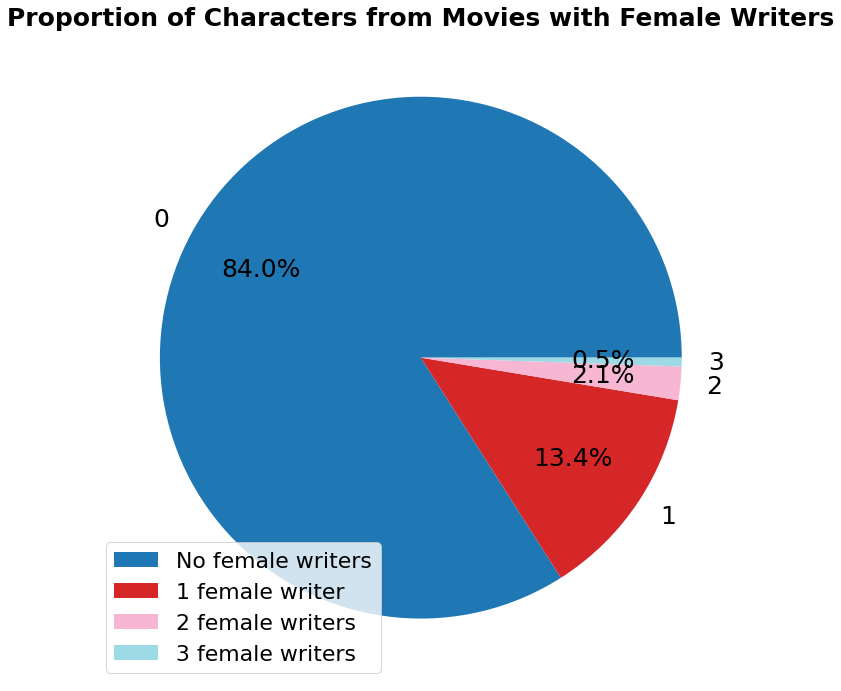

In [210]:
piechart = dialogue_no_missing_ids.num_of_female_writers.value_counts().plot(kind = 'pie', 
                                                              figsize=(12,12), 
                                                              autopct = "%.1f%%", 
                                                              pctdistance = 0.7,
                                                              colormap = 'tab20',
                                                              textprops={'fontsize': 25})
                                                         
                                                  
piechart.set_title('Proportion of Characters from Movies with Female Writers', fontweight="bold", size=25)
labels = ['No female writers', '1 female writer', '2 female writers', '3 female writers']
piechart.legend(labels,loc = 'lower left', fontsize = 22)
piechart.set_ylabel('')